In [1]:
#Various Python modules for basic needs.
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

#Core Libra routines for model potentials, data types, etc.
from liblibra_core import *
import util.libutil as comn
import libra_py.data_savers as data_savers

#QTAG modules implemented in Libra.
import libra_py.dynamics.qtag.compute as compute
import libra_py.dynamics.qtag.initialize as initialize
import libra_py.dynamics.qtag.plot as plot
import libra_py.dynamics.qtag.save as save

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<float> >, std::allocator<std::vector<float, std::allocator<float> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWar

In [2]:
class tmp:
    pass

In [3]:
def SAC_mimic(q, params, full_id):
    critical_params = [ ]
    default_params = {"A":0.010, "B":1.600, "C":0.005, "D":1.000}
    comn.check_input(params, default_params, critical_params)

    A = params["A"]
    B = params["B"]
    C = params["C"]
    D = params["D"]

    Id = Cpp2Py(full_id)
    indx = Id[-1]
    x = q.col(indx).get(0)
    
    Hdia = CMATRIX(2,2)
    Sdia = CMATRIX(2,2)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(2,2) )
    d2ham_dia = CMATRIXList();  d2ham_dia.append( CMATRIX(2,2) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(2,2) )

    Sdia.set(0,0, 1.0+0.0j);  Sdia.set(0,1, 0.0+0.0j);
    Sdia.set(1,0, 0.0+0.0j);  Sdia.set(1,1, 1.0+0.0j);

    V11, dV11, d2V11 = 0.0, 0.0, 0.0
    V22, dV22, d2V22 = 0.0, 0.0, 0.0
    V12, dV12, d2V12 = 0.0, 0.0, 0.0
    
    th = np.tanh(B*x)
    e = np.exp(-D*x*x)
    
    V11 = A*(1.0+th)
    V22 = A*(1.0-th)
    V12 = C*e

    dV11 = A*B*(1-th*th)
    dV22 = -A*B*(1.0-th*th)
    dV12 = -2.0*x*C*D*e
    
    d2V11 = -2.0*A*B*B*th*(1.0-th*th)
    d2V22 = 2.0*A*B*B*th*(1.0-th*th)
    d2V12 = 4.0*C*D*e*(D*x*x-0.5)

    Hdia.set(0,0, V11*(1.0+0.0j));  Hdia.set(0,1, V12*(1.0+0.0j));
    Hdia.set(1,0, V12*(1.0+0.0j));  Hdia.set(1,1, V22*(1.0+0.0j));

    for i in [0]:
        d1ham_dia[i].set(0,0, dV11*(1.0+0.0j));  d1ham_dia[i].set(0,1, dV12*(1.0+0.0j));
        d1ham_dia[i].set(1,0, dV12*(1.0+0.0j));  d1ham_dia[i].set(1,1, dV22*(1.0+0.0j));

        d2ham_dia[i].set(0,0, d2V11*(1.0+0.0j));  d2ham_dia[i].set(0,1, d2V12*(1.0+0.0j));
        d2ham_dia[i].set(1,0, d2V12*(1.0+0.0j));  d2ham_dia[i].set(1,1, d2V22*(1.0+0.0j));
        
        #  <dia| d/dR_0| dia >
        dc1_dia[i].set(0,0, 0.0+0.0j);  dc1_dia[i].set(0,1, 0.0+0.0j);
        dc1_dia[i].set(1,0, 0.0+0.0j);  dc1_dia[i].set(1,1, 0.0+0.0j);

    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.d2ham_dia = d2ham_dia
    obj.dc1_dia = dc1_dia

    return obj

In [4]:
def DAC_mimic(q, params, full_id):
    critical_params = [ ]
    default_params = {"A":0.1, "B":0.028, "C":0.015, "D":0.06, "E":0.05}
    comn.check_input(params, default_params, critical_params)

    A = params["A"]
    B = params["B"]
    C = params["C"]
    D = params["D"]
    E = params["E"]

    Id = Cpp2Py(full_id)
    indx = Id[-1]
    x = q.get(0,indx)
    
    Hdia = CMATRIX(2,2)
    Sdia = CMATRIX(2,2)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(2,2) )
    d2ham_dia = CMATRIXList();  d2ham_dia.append( CMATRIX(2,2) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(2,2) )

    Sdia.set(0,0, 1.0+0.0j);  Sdia.set(0,1, 0.0+0.0j);
    Sdia.set(1,0, 0.0+0.0j);  Sdia.set(1,1, 1.0+0.0j);

    V11, dV11, d2V11 = 0.0, 0.0, 0.0
    V22, dV22, d2V22 = 0.0, 0.0, 0.0
    V12, dV12, d2V12 = 0.0, 0.0, 0.0
    
    b22 = np.exp(-B*x*x)
    e = np.exp(-D*x*x)
    
    V11 = 0.0
    V22 = -A*b22+E
    V12 = C*e
    
    dV11 = 0.0
    dV22 = 2.0*A*B*x*b22
    dV12 = -2.0*x*C*D*e
    
    d2V11 = 0.0
    d2V22 = 2.0*A*B*b22*(1.0-2.0*B*x*x)
    d2V12 = 4.0*C*D*e*(D*x*x-0.5)

    Hdia.set(0,0, V11*(1.0+0.0j));  Hdia.set(0,1, V12*(1.0+0.0j));
    Hdia.set(1,0, V12*(1.0+0.0j));  Hdia.set(1,1, V22*(1.0+0.0j));

    for i in [0]:
        d1ham_dia[i].set(0,0, dV11*(1.0+0.0j));  d1ham_dia[i].set(0,1, dV12*(1.0+0.0j));
        d1ham_dia[i].set(1,0, dV12*(1.0+0.0j));  d1ham_dia[i].set(1,1, dV22*(1.0+0.0j));

        d2ham_dia[i].set(0,0, d2V11*(1.0+0.0j));  d2ham_dia[i].set(0,1, d2V12*(1.0+0.0j));
        d2ham_dia[i].set(1,0, d2V12*(1.0+0.0j));  d2ham_dia[i].set(1,1, d2V22*(1.0+0.0j));
        
        #  <dia| d/dR_0| dia >
        dc1_dia[i].set(0,0, 0.0+0.0j);  dc1_dia[i].set(0,1, 0.0+0.0j);
        dc1_dia[i].set(1,0, 0.0+0.0j);  dc1_dia[i].set(1,1, 0.0+0.0j);

    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.d2ham_dia = d2ham_dia
    obj.dc1_dia = dc1_dia

    return obj

In [5]:
def compute_model(q, model_params, full_id):

    model = model_params["model"]
    res = None
    
    if model==0:
        res = SAC_mimic(q, model_params, full_id)
    elif model==1:
        res = DAC_mimic(q, model_params, full_id)
    else:
        print("Unrecognized model! Check for correct model import statement.")

    return res

In [6]:
#Potential parameters for SAC
model_params = {
    "model":0,
    "deriv_lvl":2, #1 for BAT, 2 for LHA
    "A":0.01,
    "B":1.147,
    "C":0.005,
    "D":1.0,
    "ex_cpl_A":0.005,
    "ex_cpl_B":1.0,
    "ex_cpl_C":0.0
}

#Potential parameters for DAC
#model_params = {
#    "model":1,
#    "deriv_lvl":1, #1 for BAT, 2 for LHA
#    "A":0.1,
#    "B":0.28,
#    "C":0.015,
#    "D":0.06,
#    "E":0.05,
#    "ex_cpl_A":0.015,
#    "ex_cpl_B":0.06,
#    "ex_cpl_C":0.0
#}

In [7]:
#Parameters for general simulation, SAC
if model_params["model"]==0:
    dyn_params = {
    "init_placement":0,
    "wfc_q0":[-5.0], "wfc_p0":[10.0], "wfc_a0":[2.0], "wfc_s0":[0.0],
    "states":[0, 1], "grid_dims":[35], "alp_scl":[15.0], "rho_cut":1e-12   
    }

#Parameters for general simulation, DAC
elif model_params["model"]==1:
    dyn_params = {
    "init_placement":0,
    "wfc_q0":[-5.0], "wfc_p0":[10.0], "wfc_a0":[2.0], "wfc_s0":[0.0],
    "states":[0, 1], "grid_dims":[35], "alp_scl":[25.0], "rho_cut":1e-12
    }

else:
    print("Unrecognized model! Check for correct model import statement.")

ntraj, Q, P, A, S, active_states = initialize.initialize(dyn_params)

In [8]:
Q0 = MATRIX(1,1); Q0.set(0,0, dyn_params['wfc_q0'][0])
P0 = MATRIX(1,1); P0.set(0,0, dyn_params['wfc_p0'][0])
A0 = MATRIX(1,1); A0.set(0,0, dyn_params['wfc_a0'][0])
S0 = MATRIX(1,1); S0.set(0,0, dyn_params['wfc_s0'][0])
istate = [0]

C = initialize.coeffs(Q0, P0, A0, S0, istate, Q, P, A, S, active_states)

In [9]:
# 1D mass, SAC and DAC
iM = MATRIX(1, 1);  iM.set(0,0,0.0005);

#Parameters for general simulation, SAC and DAC
dyn_params = {
    "target_states":[0,1], "states":[0,1],
    "dt":1, "nsteps":2000, "iM":iM,
    "hdf5_output_level":0, "txt2_output_level":3, 
    "properties_to_save":["time","Etot","pops","q","p","a","coeffs"],
    "q_update_method":1, "p_update_method":1, "a_update_method":1, "s_update_method":0,  
    "q_sync_method":1, "p_sync_method":0, "a_sync_method":0, "s_sync_method":0,
    "mom_calc_type":1, "linfit_beta":1e-3, "d_weight":1.0, "qtag_pot_approx_method":3
}

#SAC-specific dynamic parameters
if model_params["model"]==0:
    dyn_params.update({ "decpl_den":0.1, "prefix":"SAC"})

#DAC-specific dynamic parameters
elif model_params["model"]==1:
    dyn_params.update({ "decpl_den":0.01, "prefix":"DAC"})

else:
    print("Unrecognized model! Check for correct model import statement.")

compute.run_qtag(Q, P, A, S, active_states, C, iM, dyn_params, compute_model, model_params)

0.02550026645876365 [0.9999999999950792, 1.7321706129594917e-20]
0.025500266458703933 [0.9999999999928871, 1.611839113266086e-19]
0.025500266458876132 [0.9999999999994184, 4.6293395905049255e-19]
0.025500266458846812 [0.9999999999984709, 9.381809028583804e-19]
0.025500266458941327 [1.0000000000021179, 1.6036116039443699e-18]
0.025500266458942007 [1.0000000000019655, 2.4770568160380224e-18]
0.025500266458598538 [0.9999999999883761, 3.577556465689579e-18]
0.02550026645881588 [0.9999999999962843, 4.925435543587093e-18]
0.025500266458772698 [0.9999999999941143, 6.542383748376789e-18]
0.025500266458728778 [0.9999999999919088, 8.451533835932367e-18]
0.025500266458647218 [0.9999999999884128, 1.0677554343912953e-17]
0.025500266459241677 [1.0000000000110005, 1.3246734159142287e-17]
0.025500266459211846 [1.000000000009236, 1.6187085420471338e-17]
0.025500266459264537 [1.0000000000106477, 1.9528455888843328e-17]
0.025500266459201316 [1.0000000000078892, 2.3302629500724854e-17]
0.02550026645935687

0.025500266482941042 [1.0000000000012064, 1.7746754716646365e-13]
0.02550026648336381 [0.9999999999931812, 1.8946446144285342e-13]
0.02550026648389807 [0.9999999999888785, 2.022720306116618e-13]
0.02550026648443776 [0.9999999999840411, 2.1594481673343385e-13]
0.0255002664850923 [0.9999999999833659, 2.305410176907754e-13]
0.02550026648556531 [0.9999999999748711, 2.461227061097387e-13]
0.02550026648608439 [0.9999999999670872, 2.627560815552857e-13]
0.025500266486765406 [0.99999999996576, 2.805117411362748e-13]
0.025500266487451656 [0.9999999999638062, 2.994649698076702e-13]
0.025500266488390787 [0.9999999999709084, 3.1969604194293623e-13]
0.02550026648912461 [0.9999999999692296, 3.4129054927007896e-13]
0.025500266489982208 [0.9999999999717962, 3.6433974920741183e-13]
0.025500266490857893 [0.9999999999745827, 3.889409290728643e-13]
0.025500266491937658 [0.9999999999852035, 4.1519779962517493e-13]
0.025500266492799524 [0.9999999999859818, 4.432209135522549e-13]
0.025500266493738356 [0.9999

0.02550026685820922 [0.9999999992948114, 5.525944882516714e-10]
0.025500266866309695 [0.9999999992651766, 5.85872895779417e-10]
0.025500266874536555 [0.9999999992332783, 6.211030284563326e-10]
0.025500266882767186 [0.999999999192764, 6.583959668091189e-10]
0.025500266891031225 [0.9999999991458682, 6.978689007035636e-10]
0.025500266899824015 [0.999999999110157, 7.396454523962792e-10]
0.025500266908232 [0.999999999050453, 7.838560156874734e-10]
0.025500266917153083 [0.9999999990032847, 8.306381124155638e-10]
0.025500266926273142 [0.9999999989535382, 8.801367669043247e-10]
0.025500266935451564 [0.9999999988967413, 9.32504898861336e-10]
0.02550026694483083 [0.9999999988380847, 9.879037360932994e-10]
0.025500266954220578 [0.9999999987692231, 1.046503247958878e-09]
0.02550026696380263 [0.9999999986978242, 1.1084825999933518e-09]
0.025500266973893952 [0.9999999986343713, 1.1740306315158482e-09]
0.02550026698420793 [0.9999999985697733, 1.2433463563231207e-09]
0.025500266994672553 [0.9999999984

0.025500271034276857 [0.9999995127240537, 4.869833638857833e-07]
0.025500271119090194 [0.9999994897024537, 5.100078582198813e-07]
0.02550027120537431 [0.9999994656437046, 5.340668221917492e-07]
0.025500271292998856 [0.9999994404968604, 5.592040535727639e-07]
0.025500271382659985 [0.9999994142443306, 5.854650777886016e-07]
0.025500271473891282 [0.999999386817014, 6.128972103828525e-07]
0.025500271566674712 [0.9999993581649516, 6.415496214909454e-07]
0.02550027166099199 [0.9999993282370621, 6.714734024056171e-07]
0.025500271757008815 [0.9999992969837922, 7.027216342558915e-07]
0.025500271854846258 [0.9999992643534876, 7.353494588832555e-07]
0.02550027195465716 [0.9999992302922611, 7.694141519486345e-07]
0.02550027205606879 [0.9999991947277534, 8.049751983777387e-07]
0.025500272159369865 [0.999999157606512, 8.420943701386282e-07]
0.02550027226455403 [0.9999991188631264, 8.808358064775786e-07]
0.025500272371584625 [0.9999990784278773, 9.212660966492678e-07]
0.025500272480685343 [0.99999903

0.02550011566269831 [0.999917543133388, 8.245642238988136e-05]
0.025500097198584974 [0.9999147379688832, 8.52615792552809e-05]
0.02550007866178381 [0.9999118455848554, 8.8153961666494e-05]
0.02550006038077043 [0.9999088635511358, 9.113599170330234e-05]
0.025500042032663664 [0.9999057893840902, 9.421014930967105e-05]
0.02550002362044777 [0.9999026205531509, 9.73789733769722e-05]
0.025500005474348286 [0.999899354463461, 0.00010064506288769793]
0.025499987268917664 [0.9998959884354236, 0.00010401107805242607]
0.025499969007099766 [0.9998925197695785, 0.0001074797414304889]
0.02549995102006366 [0.9998889456691257, 0.00011105383911764686]
0.025499932651187954 [0.9998852632847103, 0.00011473622189556667]
0.025499914562074386 [0.999881469699291, 0.00011852980641647598]
0.025499896424194667 [0.9998775619097471, 0.0001224375764411494]
0.02549987857122752 [0.9998735368944582, 0.00012646258405152192]
0.02549986034215915 [0.9998693915193835, 0.00013060795085472024]
0.0254998424016976 [0.9998651225

0.025496059516227458 [0.9969803703114349, 0.003019628283878004]
0.025495997215428643 [0.9969108457600896, 0.0030891528212475803]
0.02549593436263304 [0.9968399461686815, 0.003160052402816712]
0.025495870651517673 [0.9967676496377488, 0.0032323489149973473]
0.02549580637675867 [0.9966939340570712, 0.0033060644813939204]
0.025495741246070736 [0.9966187770582554, 0.003381221463288744]
0.025495675540915416 [0.9965421560526531, 0.003457842460068092]
0.02549560898264786 [0.9964640481910616, 0.0035359503096540823]
0.025495541839250235 [0.9963844303874639, 0.003615568088838689]
0.025495473846486868 [0.9963032793457295, 0.0036967191136455125]
0.025495405118470423 [0.9962205715081536, 0.0037794269391467753]
0.025495335791239082 [0.9961362830735183, 0.003863715360565883]
0.025495265621039223 [0.9960503900079537, 0.00394960841305914]
0.025495194711669705 [0.9959628680344695, 0.00403713037141112]
0.025495123062229202 [0.9958736926430549, 0.00412630575057522]
0.02549505079719068 [0.9957828390780321,

0.025482420768440324 [0.9660423858918167, 0.03395760962727324]
0.025482287751007814 [0.9655346257607939, 0.03446536971853165]
0.025482154622417905 [0.9650210704527505, 0.034978924990346015]
0.025482021456578213 [0.9645016822208708, 0.03549831317414237]
0.02548188826870985 [0.9639764235072378, 0.03602357184527733]
0.025481755073381376 [0.9634452568894394, 0.03655473841669082]
0.02548162188586146 [0.9629081451409517, 0.03709185013266203]
0.025481488720247504 [0.9623650511650592, 0.037634944062435324]
0.025481355591673725 [0.9618159380890009, 0.038184057093895926]
0.025481222514781767 [0.961260769204697, 0.03873922592718628]
0.025481089504637563 [0.9606995080192027, 0.03930048706834757]
0.02548095657556933 [0.9601321182085119, 0.039867876822907135]
0.025480823742875622 [0.9595585636942306, 0.0404414312895165]
0.025480691021110512 [0.9589788085837787, 0.04102118635345881]
0.02548055842503763 [0.958392817210349, 0.04160717768030414]
0.025480425743767625 [0.957800554133216, 0.042199440707583

0.02546715744449953 [0.838580551498174, 0.16141941252497205]
0.02546707682297112 [0.8371134671024113, 0.1628864969078144]
0.02546699745886286 [0.8356391410357378, 0.16436082296451282]
0.025466918551642855 [0.8341576018888746, 0.1658423620988011]
0.025466839283359556 [0.8326688789119859, 0.16733108505612723]
0.025466761121783064 [0.8311730020190645, 0.16882696192720484]
0.025466682669037354 [0.829670001785708, 0.17032996214920113]
0.025466605374911522 [0.8281599094015748, 0.17184005450647533]
0.02546652850945683 [0.8266427567566556, 0.17335720713464114]
0.02546645116807846 [0.8251185763521385, 0.17488138752397234]
0.02546637505069124 [0.8235874013296672, 0.17641256252092985]
0.025466298547062765 [0.8220492655075645, 0.17795069832943217]
0.025466223170347337 [0.8205042032940638, 0.17949576051500407]
0.02546614730939234 [0.8189522497815794, 0.18104771400933078]
0.025466072627279027 [0.8173934406501431, 0.18260652311182102]
0.025465998328381284 [0.8158278122518807, 0.18417215149134278]
0.0

0.025457006588137526 [0.5957411595694753, 0.4042587962875555]
0.02545690976406682 [0.5937590427903114, 0.4062409129790889]
0.02545681165975096 [0.5917774483153451, 0.40822250736529997]
0.025456713321160878 [0.589796443568239, 0.4102035120318416]
0.025456614370601344 [0.5878160957627502, 0.4121838597521572]
0.02545651435385549 [0.5858364719219431, 0.41416348349959564]
0.025456414109519182 [0.5838576388753307, 0.41614231645145344]
0.025456312791308947 [0.5818796632400117, 0.418120291995072]
0.02545621143284015 [0.579902611408426, 0.4200973437340219]
0.02545610877952904 [0.5779265495563325, 0.4220734054947602]
0.025456005888393616 [0.5759515436278309, 0.424048411333751]
0.025455901910396345 [0.5739776593296471, 0.4260222955426207]
0.025455797689343793 [0.5720049621281079, 0.4279949926547273]
0.025455692828822492 [0.5700335172348601, 0.42996643744876545]
0.025455586854511603 [0.5680633896248379, 0.43193656495942206]
0.025455480647885234 [0.5660946440074899, 0.4339053104814223]
0.0254553734

0.025438210011178557 [0.35561355109367626, 0.6443863853624596]
0.025438038692796008 [0.35417182611211834, 0.6458281101242196]
0.025437867598331186 [0.3527362764377434, 0.6472636595772479]
0.025437695871361042 [0.3513069122712783, 0.6486930235177351]
0.02543752393901464 [0.34988374338020944, 0.6501161921832767]
0.025437352252574368 [0.3484667790761223, 0.6515331562629763]
0.025437179966826134 [0.3470560282220666, 0.6529439068889618]
0.025437007937565516 [0.3456514992476864, 0.6543484356339858]
0.025436835325393894 [0.3442532001382476, 0.6557467345095144]
0.025436662980145058 [0.34286113844918903, 0.6571387959624393]
0.025436490068502956 [0.34147532130334624, 0.6585246128736042]
0.02543631699887246 [0.34009575539103937, 0.6599041785480856]
0.025436144203465356 [0.33872244697391785, 0.6612774867257114]
0.025435970874067956 [0.33735540188715385, 0.6626445315728068]
0.025435797828846383 [0.33599462553785875, 0.6640053076782625]
0.02543562426576942 [0.3346401229190406, 0.6653598100522999]
0.

0.02541588771450242 [0.21731192599492632, 0.7826879579889326]
0.025415736320155716 [0.21664539933915755, 0.7833544839571297]
0.025415587520984072 [0.21598360692652593, 0.7840162756721842]
0.025415437027105903 [0.21532652590909437, 0.7846733559866238]
0.02541528688683007 [0.2146741333830383, 0.7853257478007805]
0.025415137098307214 [0.2140264064031448, 0.7859734740600539]
0.025414987659604777 [0.213383321982673, 0.7866165577531201]
0.025414840872693144 [0.21274485708779825, 0.7872550219083251]
0.025414692347739576 [0.2121109886590365, 0.7878888895922448]
0.02541454418126569 [0.21148169358970165, 0.7885181839077189]
0.025414396371056885 [0.21085694874355643, 0.7891429279909874]
0.02541424891474377 [0.21023673095257153, 0.7897631450095484]
0.025414104220139736 [0.2096210170175219, 0.7903788581594067]
0.025413957691304258 [0.20900978372261142, 0.7909900906631098]
0.025413811524046055 [0.20840300781398344, 0.7915968657684403]
0.025413665715783504 [0.2078006660246611, 0.7921992067453946]
0.0

0.02539958605204383 [0.16126372525272192, 0.8387358643274364]
0.02539949217313895 [0.16103311107231497, 0.8389664728928046]
0.02539940191597751 [0.16080441813636745, 0.8391951601121284]
0.0253993136787779 [0.16057763059075914, 0.8394219417072084]
0.0253992243095625 [0.16035273257261834, 0.8396468337960217]
0.02539913538971106 [0.16012970839122473, 0.8398698519442801]
0.025399048568626178 [0.1599085424854007, 0.8400910115702692]
0.02539896054144188 [0.1596892192766829, 0.8403103285219098]
0.025398872964936498 [0.1594717233676783, 0.8405278180658468]
0.02539878584017433 [0.15925603945630096, 0.8407434955024368]
0.025398700914536266 [0.1590421523718406, 0.8409573758452581]
0.025398611562030306 [0.15883004691833696, 0.8411694745882559]
0.025398525778463164 [0.15861970807130332, 0.8413798066055457]
0.025398440444809593 [0.15841112091897197, 0.8415883868103446]
0.025398357415038434 [0.15820427068421197, 0.8417952298106858]
0.02539827297451342 [0.15799914255361475, 0.8420003507401077]
0.02539

0.025391672101972036 [0.14260774471632484, 0.8573891552937085]
0.02539164789353949 [0.14252767959072785, 0.8574691717067319]
0.02539161831966117 [0.1424482018070452, 0.8575486013383797]
0.025391597519238553 [0.1423693067419722, 0.8576274462786935]
0.02539157742504301 [0.14229098920279043, 0.8577057129162381]
0.02539154948468099 [0.14221324344457834, 0.8577834083825525]
0.025391530607679385 [0.14213606502723883, 0.8578605344432974]
0.025391503755898704 [0.14205944829882874, 0.8579370994406375]
0.02539148614968565 [0.14198338894287166, 0.8580131049388702]
0.025391460392401626 [0.14190788139598706, 0.8580885592770495]
0.025391444067626653 [0.1418329214641238, 0.8581634638091872]
0.02539141941145102 [0.1417585036710075, 0.8582378268757652]
0.025391404379871925 [0.14168462394487516, 0.8583116496192813]
0.025391378795466626 [0.1416112769020427, 0.8583849403855902]
0.025391365070439643 [0.1415384585560748, 0.8584577001231094]
0.025391342641278115 [0.14146616360375627, 0.8585299371876386]
0.02

0.025395065066984707 [0.13564656343715373, 0.8643326720351959]
0.025395170509108472 [0.1356154805079903, 0.864363485941913]
0.025395248278526596 [0.13558463258682646, 0.8643940694037795]
0.025395356128942777 [0.13555402135561728, 0.8644244058811825]
0.02539546613816901 [0.13552364603426356, 0.8644545030821854]
0.025395546941068006 [0.1354935031329937, 0.8644843728124356]
0.02539565853449805 [0.13546359442565623, 0.8645139977601046]
0.025395772338807156 [0.1354339191797107, 0.864543385793863]
0.025395856161192762 [0.1354044738987782, 0.8645725489977616]
0.025395971510756087 [0.13537526044583117, 0.8646014694842759]
0.025396089124298644 [0.13534627813085595, 0.8646301552937959]
0.025396175971359045 [0.1353175234488221, 0.8646586187949605]
0.025396295086349163 [0.13528899834418212, 0.8646868415240961]
0.02539641651858706 [0.13526070216964206, 0.8647148316989818]
0.02539653933754055 [0.13523263420941536, 0.8647425902646677]
0.02539663026634768 [0.135204790935819, 0.8647701297400977]
0.0253

0.025422739542577392 [0.13334265788534577, 0.8665638504416004]
0.025423106069873296 [0.1333377681501858, 0.8665678328730624]
0.025423398830896646 [0.13333302853989573, 0.8665716858751995]
0.025423760910547776 [0.13332843887148763, 0.8665753597480402]
0.02542412844504076 [0.13332399813397333, 0.8665788774153829]
0.02542449654808181 [0.13331970514426386, 0.8665822416948922]
0.025424788809891796 [0.13331555803569606, 0.8665854813059332]
0.02542515175082279 [0.13331155632973413, 0.8665885463115599]
0.025425519846295756 [0.13330769885406799, 0.8665914598886666]
0.02542588864630446 [0.1333039844378613, 0.866594224977628]
0.025426257444827297 [0.1333004118079933, 0.8665968429785141]
0.025426626499131993 [0.13329697974722224, 0.8665993152004198]
0.025426995422856914 [0.13329368695062163, 0.8666016429631557]
0.025427364518484392 [0.13329053215857822, 0.8666038276052369]
0.025427733380898945 [0.13328751403157604, 0.8666058704857128]
0.02542810233473096 [0.13328463127100043, 0.866607772980994]
0.

0.02549287602258757 [0.13341122963776936, 0.8663368367261491]
0.02549365590877062 [0.1334122554800263, 0.8663344792517346]
0.025494433512553316 [0.13341322690143506, 0.8663321797763543]
0.025495209250275992 [0.13341414336257443, 0.8663299386044403]
0.025495983107866365 [0.13341500460843936, 0.8663277560056581]
0.0254967550659527 [0.13341581041688647, 0.8663256322148718]
0.025497525645800212 [0.13341656031621546, 0.866323567450356]
0.025498404258722202 [0.13341724849966397, 0.8663215329009808]
0.02549917699389074 [0.13341788050379288, 0.8663195917594345]
0.025500052104209005 [0.133418450458169, 0.8663176833548274]
0.025500820796038 [0.13341896416210777, 0.8663158680940302]
0.025501692535352654 [0.13341941562092854, 0.8663140859992036]
0.025502457073205115 [0.13341981117518276, 0.8663123964875027]
0.025503324041390437 [0.133420145015247, 0.8663107403502877]
0.025504194836108426 [0.13342041702498275, 0.8663091485130809]
0.025504953283702503 [0.13342063322591033, 0.8663076500287678]
0.0255

(<liblibra_core.MATRIX at 0x7fedfdc498b0>,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 <liblibra_core.CMATRIX at 0x7fedfdc2ccf0>)

Number of files = 5


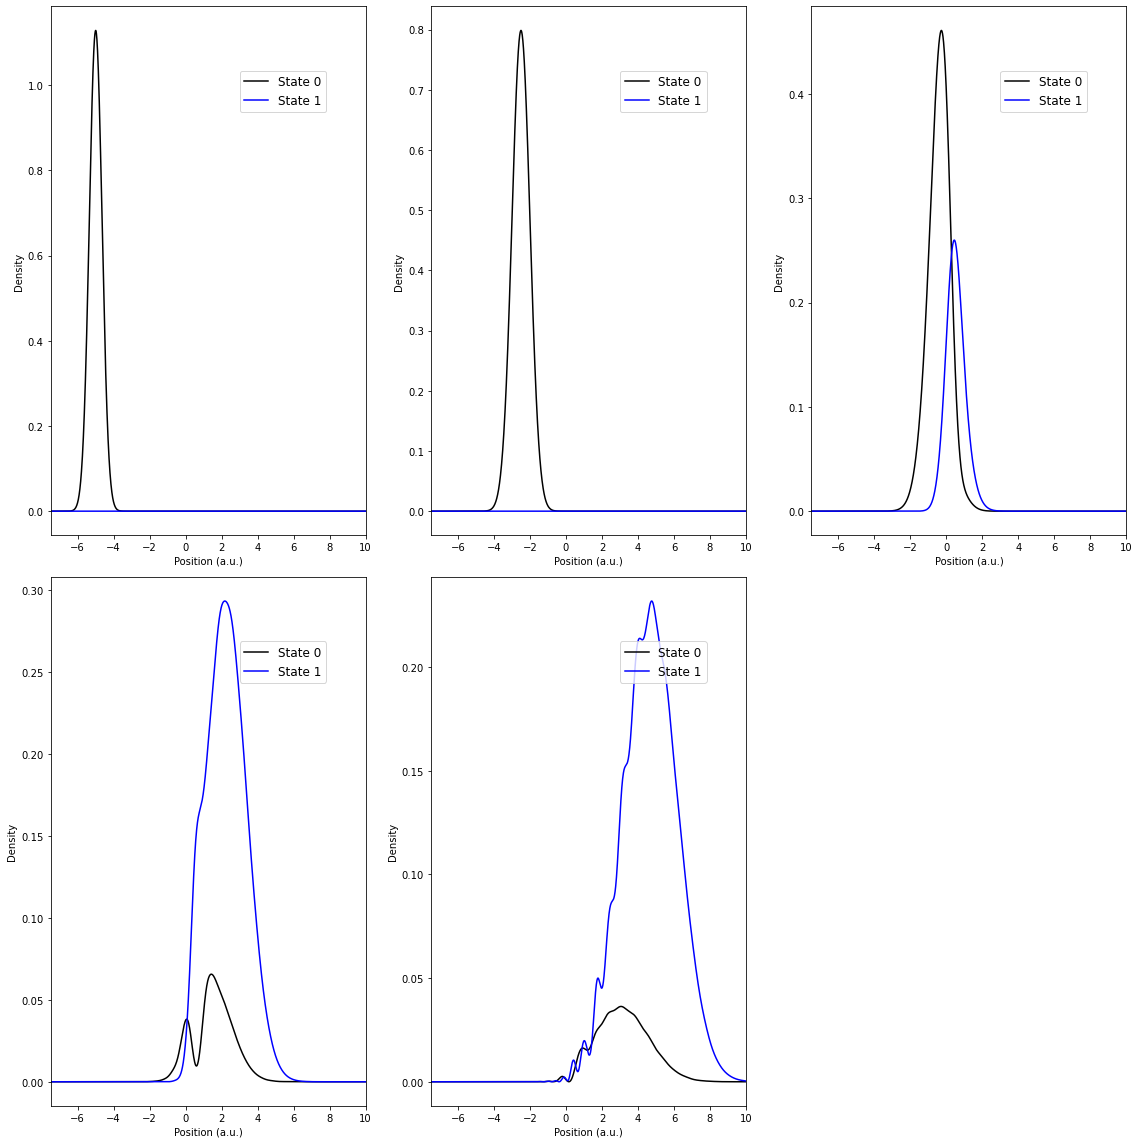

In [11]:
#Plot parameters dictionary definitions for wavefunction output...
dyn_params.update( { "ndof":1, "grid_dims":[35] })
plt_params = {'prefix':dyn_params['prefix'], 'which_states':[0,1], 
              'size':(16,16), 'xmin':[-7.5],'xmax':[10.0],
              'npoints':[2000], 'snaps':[0,499,999,1499,1999],
              'xlabel':'Position (a.u.)', 'ylabel':'Density', 'zlabel':'N/A',
              '1Dcolors':['Black','Blue'], '2Dcolors':['Reds','Blues'],
              'legend_loc':(0.6,0.8), 'legend_size':12,
              "grid_dims":dyn_params['grid_dims']
             }

#Call wf_calc_nD to calculate gridded wavefunction data from coefficients and qpas output...
compute.wf_calc_nD(dyn_params, plt_params, plt_params['prefix'])

#Plot the selected snapshots...
plot.wf_plot(dyn_params, plt_params)

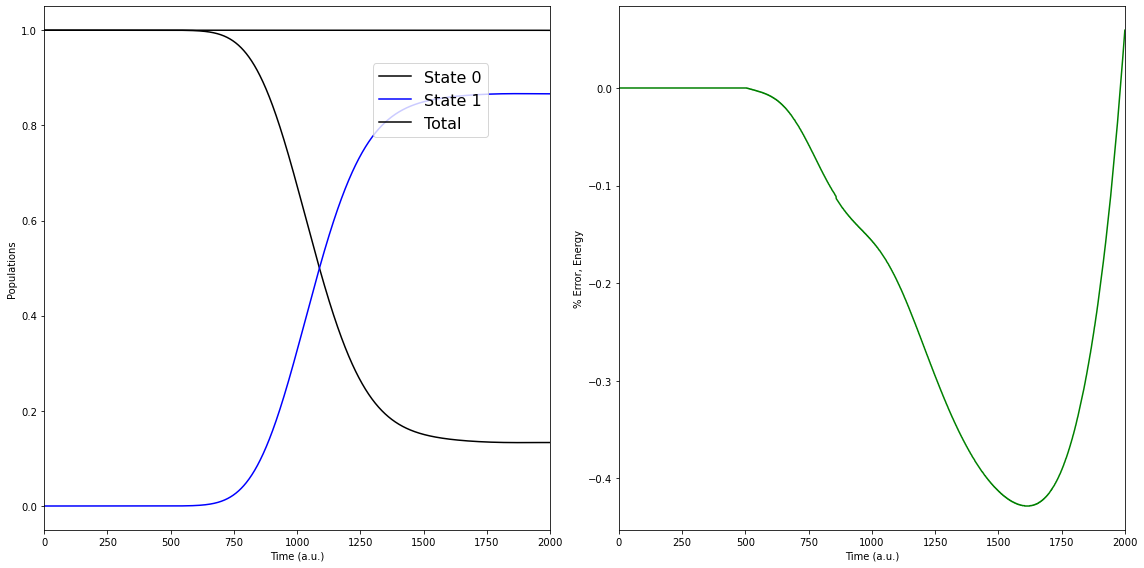

In [12]:
#Plot parameters dictionary definitions for energy/population output...
plt_params = {'prefix':dyn_params['prefix'], 'size':(16,8), 'xmin':[0], 'xmax':[2000.0], 
              '1Dcolors':['Black','Blue'], 'legend_loc':(0.65,0.75), 'legend_size':16}

#Plot the graphs...
plot.energy_and_pops(dyn_params, plt_params)

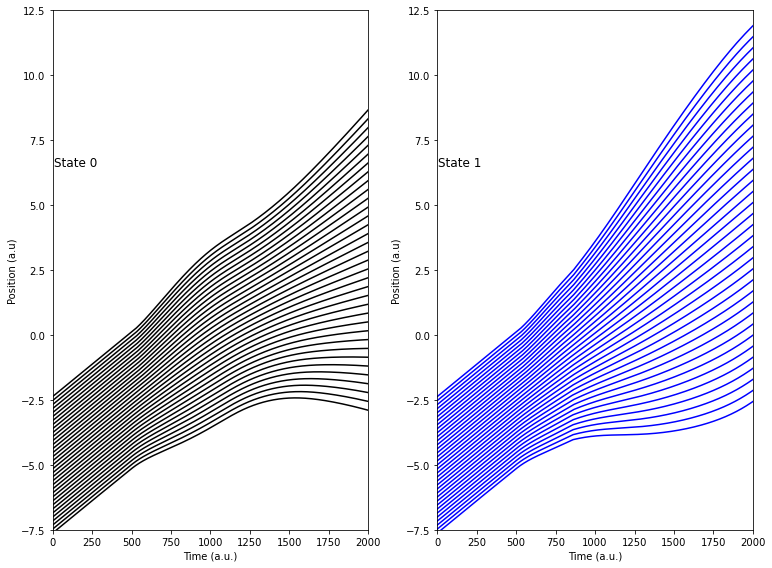

In [13]:
#Plot parameters dictionary definitions for trajectory output...
plt_params = {'prefix':dyn_params['prefix'], 'which_states':[0, 1], 'which_traj':'all', 
              'size':(16,8), 'xlabel':'Time (a.u.)', 'ylabel':'Position (a.u)', 'zlabel':'N/A',
              '1Dcolors':['Black','Blue']}

if model_params["model"]==0:
    plt_params.update({'xmin':[0,-7.5],'xmax':[2000.0,12.5]})
elif model_params["model"]==1:
    plt_params.update({'xmin':[0,-7.5],'xmax':[2000.0,30.0]})
else:
    print("Unrecognized model! Check for correct model import statement.")
    
#Plot the output...
plot.trajectories(dyn_params, plt_params)